Michał Szczurek Informatyka II rok, grupa wtorek 12:50 B

# 0. Instalacja biblioteki sorted containers (jeśli nie jest ona zainstalowana)

In [ ]:
 pip install sortedcontainers

# 1. Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE =0.09 #0.002

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1: #POPRAWA NARZĘDZIA
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim()[1]- self.ax.get_xlim()[0],
                                                                    self.ax.get_ylim()[1]- self.ax.get_ylim()[0]])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else: 
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# 2. Wykorzystane biblioteki (niezwiązane z wizualizacją)

In [3]:
import random
import math

# 3. Funkcje umożliwiające wprowadzanie danych

3.1 Funkcja wczytująca linie z wykresu

In [4]:
def lines_from_plot(plot):
    res = []
    lines_collection = plot.get_added_lines()
    for l in lines_collection:
        res = res + l.lines
    return res

3.2 Funkcje umożliwiające zapis i wczytanie danych z pliku

In [5]:
def save_lines (lines, file):
    file = open(file + ".json", 'w')
    file.write(js.dumps({"lines":lines}))
    
def load_lines(file):
    file = open(file + ".json", "r")
    data = js.load(file)
    return data['lines']

Struktura przykładowego pliku z danymi

{"lines": [[[-0.47020685866860845, -5.125919211192503], [1.6882298726997647, -9.335084626106955]], 
           [[-0.23890301004928804, -7.661112102999468], [0.8094555581474265, -3.8135081347365185]],
           [[0.08273414293210779, -9.123449863743783], [0.24728745141027897, -9.057134633507287]],
           [[1.2216578907649085, -3.9243654950110347], [1.9922328690072053, -5.0867732884001695]],
           [[0.6768774497263375, -4.671317343085699], [1.8869764689255066, -8.982769765032547]],
           [[0.1619056550377127, -7.110543886262644], [0.2281397796851503, -9.663209227191832]],
           [[0.14019557537904825, -9.410667713216265], [0.8901040719476547, -7.997142936422643]], 
           [[0.5569161956205195, -9.36426947027241], [1.2525794691395595, -6.128317776356557]]]}

3.3 Funkcja generująca losowe dane

In [6]:
def rand_lines(n, min_x, max_x, min_y, max_y):
    lines = []
    used_x = set()
    i = 0
    while (i<n):
        p1 = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        p2 = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        if p1[0] in used_x or p2[0] in used_x or p1[0] == p2[0]:
            continue
        else:
            if p1[0] < p2[0]:
                lines.append([p1,p2])
            else:
                lines.append([p2,p1])
            used_x.add(p1[0])
            used_x.add(p2[0])
            i += 1
    return lines

3.4 Wprowadzenie danych

Kod poniżej wczytuje dane z powyższego wykresu

<IPython.core.display.Javascript object>


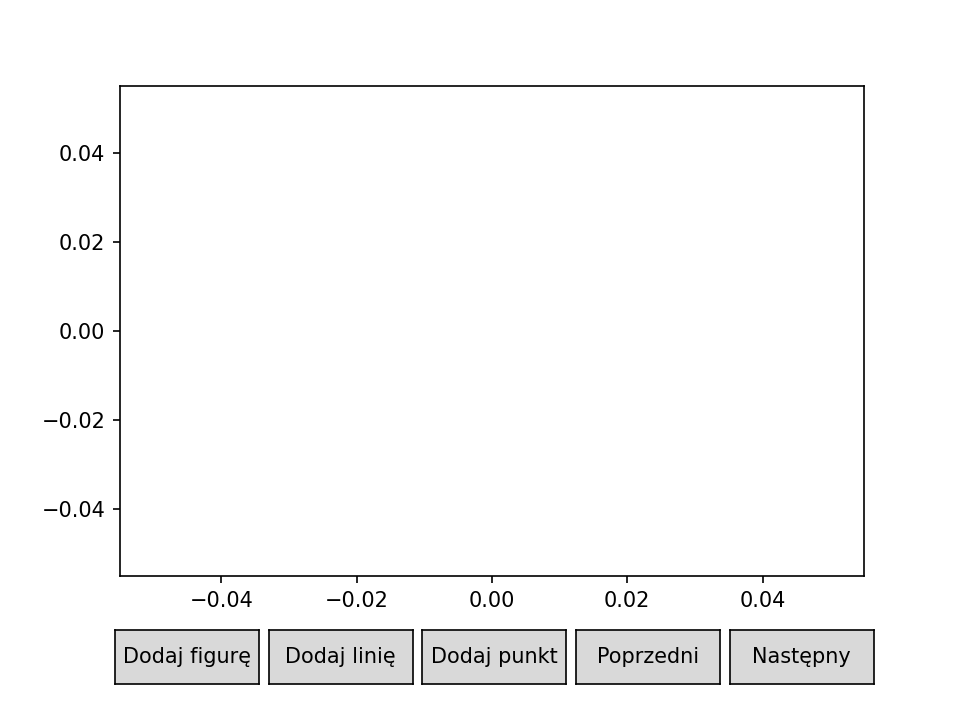

In [7]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [8]:
lines = lines_from_plot(plot)

Kod poniżej wczytuje dane z pliku o nazwie "lines.json"

In [9]:
lines = load_lines("lines")

Kod poniżej zapisuje dane do pliku o nazwie lines.json"

In [10]:
save_lines(lines,"lines")

Kod poniżej generuje losowe linie i wizualizuje je

<IPython.core.display.Javascript object>


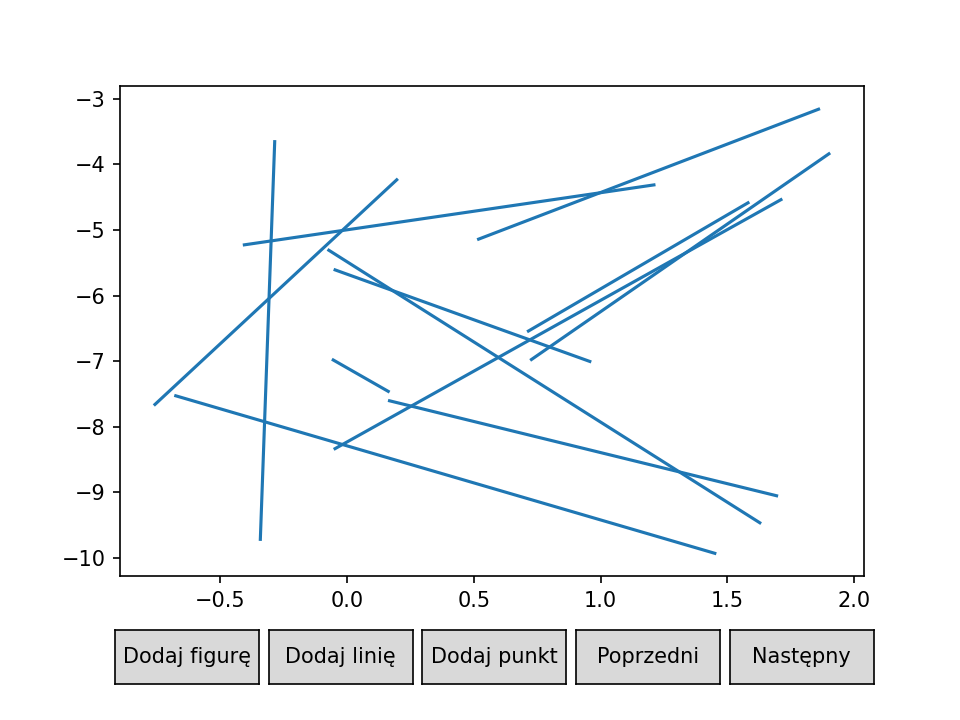

In [11]:
lines = rand_lines(12,-1.0,2.0,-10.0,-3.0) # Przykładowe wywołanie dla 8 punktów o x z przedziału (-1.0,2.0) i y (-10.0,3.0)
scene = Scene([PointsCollection([])],[LinesCollection(lines)])
plot = Plot([scene])
plot.draw()

# 4. Sprawdzanie czy dowolne dwie linie się przecinają

4.1 Funkcje i klasy użyte w programie

Obliczenie wyznacznika

In [12]:
def det(a, b, c):
    return a[0] * b[1] + b[0] * c[1] + c[0] * a[1] - c[0] * b[1] - a[0] * c[1] - b[0] * a[1]   

Funkcja signum

In [13]:
def sgn(x):
    return math.copysign(1, x)

Sprawdzanie czy dane dwie linie sięprzecinają

In [14]:
def line_segment_intersection(line_a, line_b):
    #eliminacja przypadków, gdy punktu jedna linia kończy się zanima zacznie się 2.
    if line_a.p2[0] < line_b.p1[0] or line_b.p2[0] < line_a.p1[0]:
        return False
    
    if ((min(line_a.p1[1], line_a.p2[1])> max(line_b.p1[1], line_b.p2[1])) or 
        (min(line_b.p1[1], line_b.p2[1])> max(line_a.p1[1], line_a.p2[1]))):
        return False
    
    if not (sgn(det(line_a.p1, line_a.p2, line_b.p1)) + sgn(det(line_a.p1, line_a.p2, line_b.p2)) == 0):
        return False
    
    if not (sgn(det(line_b.p1, line_b.p2, line_a.p1)) + sgn(det(line_b.p1, line_b.p2, line_a.p2)) == 0):
        return False
    
    return True

Klasa pomocnicza do porównywania lini

In [15]:
class X_cord:
    def __init__ (self, x):
        self.val = x

Reprezentacja linii

In [16]:
class Line:
    def __init__(self,line,id,X):
        self.id = id
        
        if line[0][0] < line[1][0]:
            self.p1 = line[0]
            self.p2 = line[1]
        else:
            self.p1 = line[1]
            self.p2 =  line[0]
            
        self.a = (self.p2[1] - self.p1[1])/(self.p2[0] - self.p1[0])
        self.b = self.p1[1] - self.p1[0] * self.a 
        self.X = X
        
    def calculate_y(self,x):
        return self.a * x + self.b
    
    def to_raw_line(self):
        return [self.p1, self.p2]
    
    def __eq__ (self, other):  
        return self.id == other.id 
    
    def __gt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(self.X.val) < self.calculate_y(self.X.val)
    
    def __lt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(other.X.val) > self.calculate_y(self.X.val)
    
    def __hash__(self):
        return self.id


Funkcja pomocnicza używana podczas wizualizacji

In [17]:
def state_struct_to_lines(state_struct):

    lines = []
    for l in state_struct:
        lines.append(l.to_raw_line())
    return lines

Główna funkcja

In [18]:
from sortedcontainers import SortedSet

def check_intersection(raw_lines):
    x_cord = X_cord(None)
    event_struct = [None for _ in  range(len(raw_lines)* 2)]
    min_y = raw_lines[0][0][1]
    max_y = raw_lines[0][0][1]
    lines = [Line(raw_line, i, x_cord) for (i, raw_line) in enumerate(raw_lines)]
    
    # używane do rysowania miotły
    for line in raw_lines:
        if line[0][1] > max_y:
            max_y = line[0][1] 
        if line[1][1] > max_y:
            max_y = line[1][1] 
            
        if line[0][1] < min_y:
            min_y = line[0][1] 
        if line[1][1] < min_y:
            min_y = line[1][1] 
            
    scenes=[Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black")])]

    for (i,line) in enumerate(lines):
        event_struct[i*2] = (True, line.p1[0], line) # (is start of line, x cord of event, line of event)
        event_struct[i*2 +1] = (False, line.p2[0], line)
        
    event_struct = sorted(event_struct, key = lambda x: x[1]) # lista
    state_struct = SortedSet() # SortedSet
    
    for eve in event_struct:
        x_cord.val = eve[1]
        scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                        LinesCollection(state_struct_to_lines(state_struct), color = "green"),                     
                        LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "red")]))
        
    
        if eve[0]:
     
            state_struct.add(eve[2])
            line_id = state_struct.index(eve[2])
            if line_id - 1 >= 0:
                if line_segment_intersection(eve[2], state_struct[line_id - 1]):
                    
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "red"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "green"),     
                    LinesCollection([[eve[2].p1,eve[2].p2],[state_struct[line_id - 1].p1,state_struct[line_id - 1].p2]], 
                    color = "blue")])) 
                    
                    return (True, scenes) 
                
            if line_id + 1 < len(state_struct):
                  if line_segment_intersection(eve[2], state_struct[line_id + 1]):
                  
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "red"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "green"),
                    LinesCollection([[eve[2].p1,eve[2].p2],[state_struct[line_id + 1].p1,state_struct[line_id + 1].p2]], 
                    color = "blue")])) 
                    
                    return (True, scenes) 
                   
            
        else:
            line_id = state_struct.index(eve[2])
            if line_id - 1 >= 0 and line_id + 1 < len(state_struct):
                 if line_segment_intersection( state_struct[line_id + 1], state_struct[line_id - 1]):
                        
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "red"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "green"),
                    LinesCollection([[state_struct[line_id - 1].p1,state_struct[line_id - 1].p2],
                    [state_struct[line_id + 1].p1,state_struct[line_id + 1].p2]], color = "blue")])) 
                    
                    return (True, scenes)
                    
            state_struct.remove(eve[2])
         
    return (False, scenes)

4.2 Przykładowe wywołanie funkcji

Linie znajdujące się w strukturze stanu maja kolor zielony, a linie przecinające się- niebieski

True


<IPython.core.display.Javascript object>


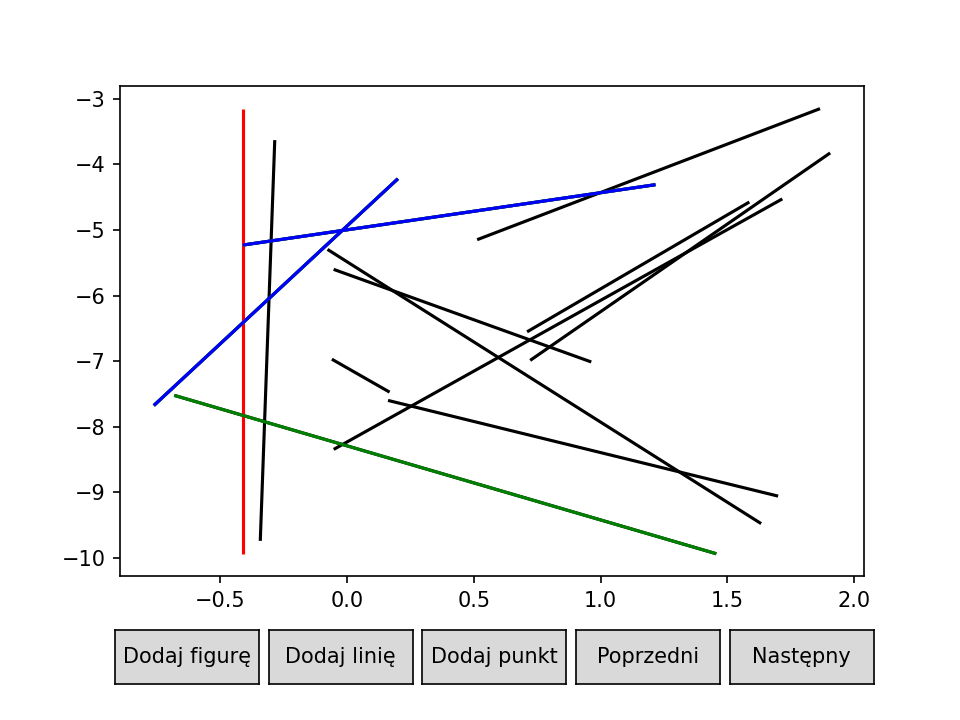

In [19]:
(res, scenes) = check_intersection(lines)
print(res)
plot = Plot(scenes)
plot.draw()

# 5. Wyznaczenie wszystkich przecięć

5.1 Funkcje i klasy użyte w programie

Reprezentacja linii

In [20]:
class Line:
    def __init__(self,line,id,X):
        self.id = id
        
        if line[0][0] < line[1][0]:
            self.p1 = line[0]
            self.p2 = line[1]
        else:
            self.p1 = line[1]
            self.p2 =  line[0]
            
        self.a = (self.p2[1] - self.p1[1])/(self.p2[0] - self.p1[0])
        self.b = self.p1[1] - self.p1[0] * self.a 
        self.X = X
        
    def calculate_y(self,x):
        return self.a * x + self.b
    
    def to_raw_line(self):
        return [self.p1, self.p2]
    
    def __eq__ (self, other):  
        return self.id == other.id 
    
    def __gt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(self.X.val) < self.calculate_y(self.X.val)
    
    def __lt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(other.X.val) > self.calculate_y(self.X.val)
    
    def __hash__(self):
        return self.id


Funkcja znajdująca punkt przecięcia dwóch lini przy założeniu, że nie są równoległe

In [21]:
def find_intersection_point(line1, line2):
    # lines have formula of y = ax + b
    x = (line2.b-line1.b)/(line1.a - line2.a)
    y = (line2.b-line1.b)/(line1.a - line2.a) * line1.a + line1.b
    return [x,y]
    

Reprezentacja zdarzenia w strulturze zdarzeń

In [22]:
class Line_event:
    def __init__ (self, type, x, line):
        self.x = x
        self.line = line
        self.type = type # B - beginning, E - ending, I - intersection
        self.line2 = None
        self.y = None
    
    def __eq__(self, other):
        # zdarzenie początku lub końca - 1 dla linii
        if self.type == other.type and self.line == other.line and self.line2 is None and other.line2 is None:
            return True
        # zdarzenie przecięcia - 1 dla pary linii
        if other.line2 is not None and self.line2 is not None:
            if (self.line == other.line and self.line2 == other.line2) or(self.line == other.line2 and self.line2 == other.line):
                return True
        return False
    
    def __hash__(self):
        return self.x.__hash__()
    
    def to_point(self):
        return [self.x,self.y]

Klasa pomocnicza do porównywania lini

In [23]:
class X_cord:
    def __init__ (self, x):
        self.val = x

Klsa pomocnicza do wizualizacji kroków algorytmu

In [24]:
class Visualizer:
    def __init__(self, min_y, max_y, raw_lines, state_struct):
        self.min_y = min_y
        self.max_y = max_y
        self.raw_lines = raw_lines
        self.state_struct = state_struct
        self.eve = None # current event
        self.scenes =[Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black")])]
        
    def add_scene(self, res_points,x):
        self.scenes.append(Scene([PointsCollection(res_points.copy(), color = "orange")],[LinesCollection(self.raw_lines, color = "black"), 
                        LinesCollection(self.state_struct.to_lines(), color = "green"),                     
                        LinesCollection([[(x, self.min_y),(x,self.max_y)]], color = "red")]))
            
    def add_scene_with_line(self, res_points, x, lines):
        raw_lines = [l.to_raw_line() for l in lines]
        self.scenes.append(Scene([PointsCollection(res_points.copy(), color = "orange")],[LinesCollection(self.raw_lines, color = "black"), 
                        LinesCollection(self.state_struct.to_lines() + raw_lines, color = "green"),                     
                        LinesCollection([[(x, self.min_y),(x,self.max_y)]], color = "red")]))

Struktura stanu

In [25]:
class State_struct:
    def __init__(self, x):
        self.lines = SortedSet()
    
    def add(self, line, event_struct,x,res,res_points, visualizer):
        self.lines.add(line)
        line_id = self.lines.index(line)

        if line_id -1>= 0:
            if line_segment_intersection(line, self.lines[line_id - 1]):
                (i_x, i_y) = find_intersection_point(line, self.lines[line_id - 1])
                eve = Line_event('I', i_x,line)
                eve.y = i_y
                eve.line2 = self.lines[line_id - 1]
                if eve not in res and eve not in event_struct:
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene(res_points, x)        
 
        if line_id + 1 < len(self.lines):
            if line_segment_intersection(line, self.lines[line_id + 1]):
                (i_x, i_y) = find_intersection_point(line, self.lines[line_id + 1])
                eve = Line_event('I', i_x,line)
                eve.y = i_y
                eve.line2 = self.lines[line_id + 1]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene(res_points, x)
            
            
    def remove(self, line, event_struct, x,res,res_points, visualizer, extra_lines = None):
        # extra lines rysuje linie, których pozornie nie ma w strukturze stanu- zostały chwilowo wyciągniete do 
        #zamiany kolejności na skutek przeccięcia
        line_id = self.lines.index(line)
        if line_id - 1 >= 0 and line_id + 1 < len(self.lines):
            if line_segment_intersection(self.lines[line_id + 1], self.lines[line_id - 1]):
                (i_x, i_y) = find_intersection_point(self.lines[line_id + 1], self.lines[line_id - 1])
                eve = Line_event('I', i_x,self.lines[line_id - 1])
                eve.y = i_y
                eve.line2 = self.lines[line_id + 1]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    if extra_lines == None:
                        visualizer.add_scene(res_points, x)
                    else:
                        visualizer.add_scene_with_line(res_points, x, extra_lines)
                    
        self.lines.remove(line)
   

    
    def interection(self,line1, line2, event_struct, x, res, res_points, visualizer, epsilon, x_cord):
        
        if line1.calculate_y(x-epsilon)< line2.calculate_y(x-epsilon):
            line1, line2 = line2, line1 #line1 będzie odcinkiem "wyższym" przed przecięciem
       
        x_cord.val = x - epsilon
        
        # usunięcie lini
        # self.remove automatycznie wykryje przecięcie line2 z linią nad line1
        self.remove(line1,event_struct, x, res,res_points, visualizer, [line1,line2])
        self.lines.remove(line2)
        x_cord.val = x + epsilon
        # dodanie linii 1. i sprawdzenie czy nie ma nowego przecięcia
        self.lines.add(line1)
         
        line_id = self.lines.index(line1)
        if line_id -1 >= 0:
            if line_segment_intersection(self.lines[line_id-1], self.lines[line_id]):
                (i_x, i_y) = find_intersection_point(self.lines[line_id], self.lines[line_id - 1])
                eve = Line_event('I', i_x,self.lines[line_id - 1])
                eve.y = i_y
                eve.line2 = self.lines[line_id]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene_with_line(res_points,x, [line2]) # linia 2. nie jest tymczasowo w zbiorze,
                    # ale powinna zostać narysowana
                    
        # dodanie lini 2.
        self.lines.add(line2)
    def to_lines(self):
        res = []
        for l in self.lines:
            res.append(l.to_raw_line())
        return res
    

Główna funkcja

In [26]:
from sortedcontainers import SortedSet

def find_intersections(raw_lines):
    epsilon = 10**(-10)
    res = SortedSet(key = lambda event : event.x) # take realizacja umożliwi efektywne sprawdzanie czy 
                                                  #zdarzenie jest już w zbiorze wynikowym
    x_cord = X_cord(None)
    res_points = []
    event_struct = SortedSet(key = lambda event : event.x)
    min_y = raw_lines[0][0][1]
    max_y = raw_lines[0][0][1]
    lines = [Line(raw_line, i, x_cord) for (i, raw_line) in enumerate(raw_lines)]
    
    for line in raw_lines:
        if line[0][1] > max_y:
            max_y = line[0][1] 
        if line[1][1] > max_y:
            max_y = line[1][1] 
            
        if line[0][1] < min_y:
            min_y = line[0][1] 
        if line[1][1] < min_y:
            min_y = line[1][1] 
            
   

    for line in lines:
        event_struct.add(Line_event('B', line.p1[0], line)) 
        event_struct.add(Line_event('E', line.p2[0], line)) 
    
    state_struct = State_struct(event_struct[0].x) # SortedSet
    
    vis = Visualizer(min_y, max_y, raw_lines,state_struct)

    while len(event_struct)> 0:
        eve = event_struct[0]
        x_cord.val = eve.x
        vis.add_scene(res_points, eve.x)

        if eve.type == 'B':
            state_struct.add(eve.line, event_struct, eve.x, res, res_points,vis)          
            
        elif eve.type == 'E':
            state_struct.remove(eve.line, event_struct, eve.x,res, res_points, vis) 
            
        else: # intersection
            res.add(eve)      
            state_struct.interection(eve.line, eve.line2, event_struct, eve.x, res, res_points, vis, epsilon, x_cord)
        
            
        event_struct.remove(eve)
    
    scenes = vis.scenes
    scenes.append(Scene([PointsCollection(res_points, color = "orange")],[LinesCollection(raw_lines, color = "black")]))  
    return (res, vis.scenes)

5.2 Przykładowe wywoałanie funkcji

Liczba punktów przecięcia:  17 

Punkt przecięcia  (-0.18606644963162458, -6.576141498029104)  przecinający linie  [[-0.9587384974664486, -6.284415037496443], [1.4696043034666895, -7.201248838151322]] i [[-0.9616433943235021, -3.3833229135952294], [0.2818091205623747, -8.502245446763]] 

Punkt przecięcia  (0.07250633547189084, -7.640608407931017)  przecinający linie  [[-0.4924067576657606, -8.140518885188374], [1.6679552826374833, -6.228742309754119]] i [[-0.9616433943235021, -3.3833229135952294], [0.2818091205623747, -8.502245446763]] 

Punkt przecięcia  (0.3254033134992019, -4.361190311552335)  przecinający linie  [[0.2764330268053876, -4.021397690765105], [1.1289801054779645, -9.937009498756499]] i [[-0.32317579387417816, -4.053454396773661], [1.7745576336138797, -5.0487808078944]] 

Punkt przecięcia  (0.3942137447343317, -4.838648753098229)  przecinający linie  [[-0.13838249429611882, -5.610462724284897], [1.2749247760093612, -3.562362837610527]] i [[0.2764330268053876, -4.02139769

<IPython.core.display.Javascript object>


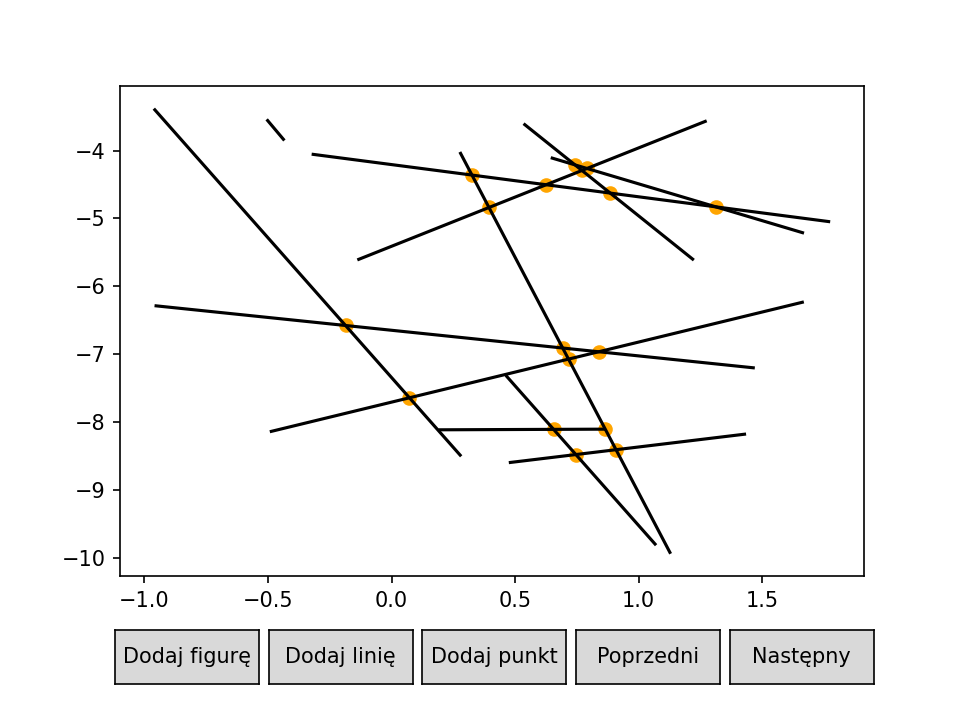

In [29]:
(res, scenes) =find_intersections(lines)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()

# 6. Dane testowe użyte w sprawozdaniu

Dane testowe 1.

In [103]:
lines =  [[[-0.030355342741935486, -0.036095856311274516], [-0.022371471774193553, 0.043101447610294136]],
           [[-0.007512600806451608, -0.029355660232843146], [-0.013722278225806454, 0.045797526041666675]], 
           [[0.0013583669354838707, -0.036095856311274516], [0.001136592741935491, 0.04175340839460784]], 
           [[0.022648689516129042, -0.03542183670343138], [0.01599546370967743, 0.040742378982843136]], 
           [[-0.03634324596774194, 0.027936006433823532], [0.03728578629032259, 0.03467620251225491]], 
           [[-0.036565020161290325, 0.002997280943627445], [0.036842237903225813, 0.007041398590686282]],
           [[-0.039669858870967745, -0.011157130821078429], [0.03462449596774195, -0.0158752680759804]], 
           [[-0.03811743951612904, 0.01310757506127451], [0.03329385080645163, 0.022880859375000007]]]

Dane testowe 2.

In [105]:
lines = [[[-0.04255292338709678, -0.04351007199754903], [0.042164818548387106, 0.0434384574142157]], 
           [[-0.04366179435483872, 0.04647154564950981], [0.04283014112903227, -0.044521101409313736]],
           [[-0.03479082661290323, -0.001046836703431378], [-0.02259324596774194, 0.0003012025122549056]],
           [[0.005350302419354844, -0.03441080729166667], [0.009342237903225817, 0.026587967218137262]],
           [[0.013334173387096776, -0.04620615042892158], [0.021318044354838722, 0.038383310355392164]]]

Dane testowe 3.

In [28]:
lines = [[[0.18938212974879365, -8.112081498451087], [0.8676482942251784, -8.102595637267372]], 
           [[-0.5051351934552246, -3.5410383687453963], [-0.43341543634956736, -3.85183137042058]],
           [[0.6441844145033775, -4.105015523224832], [1.6687295942960687, -5.2161108114941825]], 
           [[0.2764330268053876, -4.021397690765105], [1.1289801054779645, -9.937009498756499]], 
           [[-0.32317579387417816, -4.053454396773661], [1.7745576336138797, -5.0487808078944]],
           [[0.5341089452790593, -3.6042336470731673], [1.2230045738652482, -5.613164155754816]], 
           [[0.46251704954978656, -7.311241398584647], [1.0702417233928516, -9.81129362318092]], 
           [[-0.4924067576657606, -8.140518885188374], [1.6679552826374833, -6.228742309754119]],
           [[-0.13838249429611882, -5.610462724284897], [1.2749247760093612, -3.562362837610527]],
           [[-0.9616433943235021, -3.3833229135952294], [0.2818091205623747, -8.502245446763]],
           [[0.4744520807509054, -8.59558050536661], [1.434283348112154, -8.174194209808043]], 
           [[-0.9587384974664486, -6.284415037496443], [1.4696043034666895, -7.201248838151322]]]

Dane testowe 4.

In [109]:
lines = [[[-0.37697895910727386, -4.097304081882687], [0.3408301376086045, -4.61996535628482]], 
           [[-0.49693249147379026, -4.129423787102985], [0.8978566940112076, -3.276990780061766]], 
           [[-0.9392460745175779, -4.18599112489331], [-0.31569040605778675, -6.8381934831479345]], 
           [[1.2533868070628325, -7.066839140655404], [1.5457974757092492, -6.384800031095618]], 
           [[-0.46183551788735155, -3.311855832485862], [0.3696223534904828, -9.35939707347857]], 
           [[-0.8200489345191356, -5.752281999218068], [0.131926501535494, -9.64834150474892]], 
           [[0.06952633394373375, -6.150818705532822], [0.6795722378644973, -5.239222696798006]], 
           [[0.4604352067282673, -3.8224091908962885], [1.5351991770319713, -3.0269305414798264]], 
           [[0.08624918852157704, -9.533332170711677], [0.3671343804935041, -7.1208888856640735]], 
           [[0.062416269423801296, -4.29992382223157], [1.8878681787351197, -3.9557873964036316]], 
           [[-0.5489252569454105, -7.785092009372606], [0.15052258394188733, -4.14171187891572]], 
           [[-0.6302061022997759, -9.205563756208754], [0.4264492570523579, -3.553883476689414]]]

Dane testowe 5.

In [111]:
lines = [[[-0.051867439516129044, 0.019847771139705886], [-0.012391633064516128, 0.031980124080882355]], 
           [[-0.03634324596774194, 0.01917375153186275], [0.015773689516129036, 0.030632084865196085]], 
           [[-0.04011340725806452, 0.009063457414215687], [0.014221270161290323, 0.013781594669117644]], 
           [[-0.035899697580645165, -0.025985562193627458], [0.010672883064516137, -0.005090954350490201]], 
           [[0.024866431451612908, 0.040742378982843136], [0.030632560483870974, -0.016549287683823535]], 
           [[-0.02880292338709678, -0.0017208563112745129], [0.010229334677419363, 0.002997280943627445]], 
           [[-0.01837953629032258, -0.04586914062500001], [0.012890625000000003, -0.017897326899509805]], 
           [[-0.011060987903225808, 0.05422277113970589], [0.00978578629032259, 0.038383310355392164]], 
           [[0.038616431451612906, 0.036361251531862746], [0.04083417338709679, -0.011157130821078429]], 
           [[0.010451108870967743, -0.05294634650735295], [0.023092237903225815, -0.0037429151348039175]], 
           [[-0.045214213709677424, -0.0003728170955882293], [-0.03479082661290323, -0.010483111213235294]], 
           [[-0.030355342741935486, -0.015538258272058833], [-0.03235131048387097, 0.0003012025122549056]], 
           [[-0.04432711693548388, -0.021941444546568628], [-0.03323840725806452, -0.01857134650735294]]]